# Can I plot the single-cell tracks and glimpses

Using the outliers that are 1sd away from the mean of dMtb

In [1]:
import os, glob
import btrack
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from macrohet import dataio, tools, visualise
from tqdm.auto import tqdm
from scipy import stats
import pickle
import re
import cv2
from skimage import io
colors = sns.set_palette('PiYG')
track_scale_factor = 5.04

### Load metadata

In [2]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


In [3]:
base_dir = '/mnt/DATA/macrohet/'
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Load all tracks

In [4]:
tracks_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, 
                                                f'labels/macrohet_seg_model/{row,column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/06/23 11:57:33 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2023/06/23 11:57:33 AM] Loading tracks/obj_type_1
[INFO][2023/06/23 11:57:33 AM] Loading LBEP/obj_type_1
[INFO][2023/06/23 11:57:33 AM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/06/23 11:57:34 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5
[INFO][2023/06/23 11:57:34 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/23 11:57:34 AM] Loading tracks/obj_type_1
[INFO][2023/06/23 11:57:34 AM] Loading LBEP/obj_type_1
[INFO][2023/06/23 11:57:34 AM] Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
[INFO][2023/06/23 11:57:35 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5
[INFO][2023/06/23 11:57:35 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 6).h5...
[INFO][2023/06/23 11:57:35 AM] Loading tracks/obj_type_1
[INFO]

[INFO][2023/06/23 11:57:52 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5
[INFO][2023/06/23 11:57:52 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5...
[INFO][2023/06/23 11:57:52 AM] Loading tracks/obj_type_1
[INFO][2023/06/23 11:57:52 AM] Loading LBEP/obj_type_1
[INFO][2023/06/23 11:57:52 AM] Loading objects/obj_type_1 (45688, 5) (45688 filtered: None)
[INFO][2023/06/23 11:57:52 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5
[INFO][2023/06/23 11:57:52 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2023/06/23 11:57:52 AM] Loading tracks/obj_type_1
[INFO][2023/06/23 11:57:52 AM] Loading LBEP/obj_type_1
[INFO][2023/06/23 11:57:52 AM] Loading objects/obj_type_1 (45214, 5) (45214 filtered: None)
[INFO][2023/06/23 11:57:53 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5
[INFO][2023/06/23 11:57:53 AM] Opening HDF file: /mnt/DATA/macrohe

### Load cells from outlier dMtb analysis

In [5]:
# load glimpses from outliers and extract unique_IDs from them
outlier_fns = glob.glob('/mnt/DATA/macrohet/results/glimpses/interactive_plots/dMtb/*.png')
unique_IDs = [fn.split('_')[2] for fn in outlier_fns]

In [6]:
unique_IDs

['701.6.5',
 '421.3.9',
 '416.5.7',
 '166.4.6',
 '2198.5.9',
 '184.4.5',
 '701.3.4',
 '1138.3.5',
 '1809.3.9',
 '1254.4.5',
 '82.4.7',
 '1578.5.9',
 '609.4.4',
 '535.3.7',
 '114.6.7',
 '91.5.7',
 '70.5.5',
 '510.4.5',
 '2201.3.9',
 '2135.3.4',
 '2144.3.8',
 '78.4.6',
 '1894.6.5',
 '279.6.8',
 '331.3.8',
 '640.4.4',
 '513.6.8',
 '354.5.9',
 '504.5.5',
 '1254.3.6',
 '223.3.5',
 '467.5.5',
 '1118.4.7',
 '904.4.5',
 '320.4.4',
 '839.3.8',
 '1322.5.5',
 '2088.3.7',
 '546.6.4',
 '749.5.7',
 '461.4.8',
 '1805.4.6',
 '182.4.4',
 '1693.5.7',
 '905.3.8',
 '2190.6.6',
 '24.6.9',
 '2135.3.4',
 '1418.6.4',
 '1254.4.5',
 '1472.4.4',
 '78.4.6',
 '2202.3.8',
 '167.4.4',
 '314.4.7',
 '621.4.5',
 '546.6.4',
 '2180.6.5',
 '1404.5.6',
 '150.4.5',
 '897.6.8',
 '659.3.4',
 '705.5.7',
 '360.3.7',
 '902.4.9',
 '362.3.5',
 '1075.6.5',
 '470.5.8',
 '304.4.4',
 '353.6.5',
 '1065.5.4',
 '676.3.9',
 '2549.3.8',
 '688.5.7',
 '235.5.7',
 '143.4.7',
 '1418.6.4',
 '493.6.8',
 '1035.3.9',
 '299.3.6',
 '128.3.5',
 '905.

In [7]:
len(unique_IDs)

664

# Load sc_df

In [8]:
# Specify the path to your pickle file
sc_df_path = "/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_>40_interp.pkl" 
#"/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_>40.pkl"

# Load the pickle file
with open(sc_df_path, "rb") as file:
    df = pickle.load(file)

### only use GT tracks for the moment? maybe implement later

In [236]:
gt_track_dict_fn = '/mnt/DATA/macrohet/upstream_development/tracking/tracking_performance/3,5/ground_truth_tracks/(3, 5)_track_assessment.json'
# Load the JSON data from the file
with open(gt_track_dict_fn, 'r') as file:
    gt_track_dict = json.load(file)
# true_IDs = [f'{int(ID)}.3.5' for ID, status in gt_track_dict.items() if status is True]
true_IDs = [int(ID) for ID, status in gt_track_dict.items() if status is True]
true_unique_IDs = [f'{ID}.3.5' for ID in true_IDs if f'{ID}.3.5' in df['Unique ID'].unique()]#[0:20] #only do 20


In [9]:
# subset_df = df[df['Unique_ID'].isin(true_unique_IDs)] # only GT 3.5 tracks
subset_df = df[df['Unique ID'].isin(unique_IDs)] # all outlier tracks for now

In [10]:
subset_df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,Technical replicate,dMtb
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.813310,0.000000,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
1,1,725.449097,73.245003,3656.263447,369.154814,0.0,0.0,1.0,48727.0,362.852478,...,0.896474,17.860383,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
2,2,723.088928,76.431496,3644.368198,385.214738,0.0,0.0,1.0,43484.0,363.515442,...,0.876911,3.965367,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
3,3,726.009766,79.395073,3659.089219,400.151168,0.0,0.0,1.0,39113.0,360.448578,...,0.717504,4.161019,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
4,4,728.209656,82.197769,3670.176665,414.276757,0.0,0.0,1.0,32644.0,362.289764,...,0.425791,3.562951,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,1.0,0.095232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697433,70,565.650940,1081.278931,2850.880737,5449.645811,0.0,1.0,0.0,61587.0,374.370483,...,0.521127,0.963656,WT,BDQ,EC99,1202,"(6, 9)",1202.6.9,2.0,-0.835031
697434,71,566.611755,1083.470947,2855.723247,5460.693574,0.0,1.0,0.0,58778.0,372.559570,...,0.519641,2.393346,WT,BDQ,EC99,1202,"(6, 9)",1202.6.9,2.0,-0.835031
697435,72,568.148987,1081.411011,2863.470894,5450.311494,0.0,1.0,0.0,64893.0,372.814087,...,0.579433,2.570296,WT,BDQ,EC99,1202,"(6, 9)",1202.6.9,2.0,-0.835031
697436,73,570.763306,1084.552124,2876.647061,5466.142705,1.0,1.0,0.0,61917.0,374.565948,...,0.554528,4.086717,WT,BDQ,EC99,1202,"(6, 9)",1202.6.9,2.0,-0.835031


In [11]:
len(subset_df['Unique ID'].unique())

332

# Animating these graphs (making interactive)

In [136]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, output_file, ColumnDataSource, output_notebook, reset_output
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
from bokeh.models import WheelZoomTool
from bokeh.plotting import save
from bokeh.models import Label
import matplotlib.cm as cm
from bokeh.layouts import gridplot

output_notebook()

Loading BokehJS ...

# Plot Mtb time series

In [182]:
output_dir = '/mnt/DATA/macrohet/results/interactive_plots/time_series'

In [183]:
outlier_gt_IDs = [item for item in true_unique_IDs if item in unique_IDs]
outlier_gt_IDs[0]

'360.3.5'

In [184]:
test_ID = '360.3.5'

In [185]:
subset_df[subset_df['Unique ID'] == test_ID]

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,Technical replicate,dMtb
30454,0,847.173218,355.198486,4269.753018,1790.200371,0.0,0.0,1.0,49481.0,358.327667,...,0.355248,0.000000,WT,CTRL,EC0,360,"(3, 5)",360.3.5,1.0,0.263661
30455,1,853.496277,354.308807,4301.621235,1785.716389,0.0,0.0,1.0,53265.0,359.044525,...,0.736044,6.385343,WT,CTRL,EC0,360,"(3, 5)",360.3.5,1.0,0.263661
30456,2,842.024109,352.768463,4243.801509,1777.953054,0.0,0.0,1.0,64888.0,354.702789,...,0.519933,11.575115,WT,CTRL,EC0,360,"(3, 5)",360.3.5,1.0,0.263661
30457,3,849.537781,355.017242,4281.670415,1789.286902,0.0,0.0,1.0,65935.0,356.021759,...,0.735862,7.842976,WT,CTRL,EC0,360,"(3, 5)",360.3.5,1.0,0.263661
30458,5,824.011658,325.626953,4153.018755,1641.159844,1.0,0.0,1.0,44570.0,356.492065,...,0.925934,38.927780,WT,CTRL,EC0,360,"(3, 5)",360.3.5,1.0,0.263661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30523,70,841.549377,311.103424,4241.408862,1567.961257,1.0,0.0,1.0,60274.0,371.179169,...,0.859586,7.435543,WT,CTRL,EC0,360,"(3, 5)",360.3.5,1.0,0.263661
30524,71,838.685730,307.939056,4226.976079,1552.012844,1.0,0.0,1.0,48369.0,372.524048,...,0.926113,4.267751,WT,CTRL,EC0,360,"(3, 5)",360.3.5,1.0,0.263661
30525,72,844.214905,312.349091,4254.843120,1574.239417,1.0,0.0,1.0,64956.0,367.990265,...,0.881640,7.072494,WT,CTRL,EC0,360,"(3, 5)",360.3.5,1.0,0.263661
30526,73,843.035767,312.332397,4248.900264,1574.155283,1.0,0.0,1.0,58857.0,372.211029,...,0.884337,1.179256,WT,CTRL,EC0,360,"(3, 5)",360.3.5,1.0,0.263661


In [241]:
subset_df['dmtb colour codes'] = subset_df['dMtb'].apply(lambda x: cm.PiYG((x - subset_df['dMtb'].min()) / (subset_df['dMtb'].max() - subset_df['dMtb'].min())))
subset_df['dmtb colour codes'] = subset_df['dmtb colour codes'].apply(lambda x: matplotlib.colors.to_hex(x))

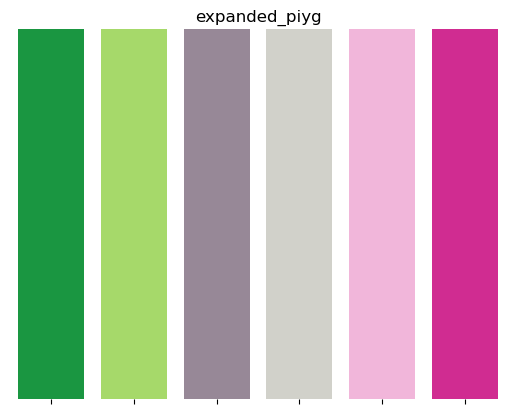

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [113]:
# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors

sns.set_palette(expanded_piyg)

# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)

expanded_piyg_dict = {
                      'WT':expanded_piyg[0], 
                      'RD1':expanded_piyg[-1],
                      'BDQ':expanded_piyg[0], 
                      'INH':expanded_piyg[1], 
                      'PZA':expanded_piyg[4], 
                      'RIF':expanded_piyg[5]}

In [192]:
#define
p1 = figure(title="title",
            plot_height = int(1080*0.4),
            tools = 'crosshair,save,pan,box_zoom,reset,wheel_zoom,hover', 
            plot_width = int(1920*0.4))
p1.toolbar.active_scroll = p1.select_one(WheelZoomTool)
p1.xaxis.axis_label = 'Time'
p1.yaxis.axis_label = 'Mtb'

p2 = figure(title="title",
            plot_height = int(1080*0.4),
            tools = 'crosshair,save,pan,box_zoom,reset,wheel_zoom,hover', 
            plot_width = int(1920*0.4))
p2.toolbar.active_scroll = p1.select_one(WheelZoomTool)
p2.xaxis.axis_label = 'Time'
p2.yaxis.axis_label = 'Mtb'

p3 = figure(title="title",
            plot_height = int(1080*0.4),
            tools = 'crosshair,save,pan,box_zoom,reset,wheel_zoom,hover', 
            plot_width = int(1920*0.4))
p3.xaxis.axis_label = 'Time'
p3.yaxis.axis_label = 'Mtb'



for ID in tqdm(unique_IDs[0:50]):
    ID_df = subset_df[subset_df['Unique ID']==ID]
    cell_ID = ID_df['Cell ID'].iloc[0]
    color = ID_df['dmtb colour codes'].iloc[0]
    strain = ID_df['Strain'].iloc[0]
    compound = ID_df['Compound'].iloc[0]
    concentration = ID_df['Concentration'].iloc[0]
    label = f'{strain}, {compound}, {concentration}'
    source = ColumnDataSource(
                                name=label,
                                data=dict(
                                x=ID_df['Time (hours)'],
                                y=ID_df['Intracellular thresholded Mtb content smooth'],
#                                 glimpse_url_t0=outlier_df['glimpse_url_t0'],
#                                 glimpse_url_tn=outlier_df['glimpse_url_tn'], 
                                dMtb=ID_df['dMtb'], 
                                cell_ID=ID_df['Cell ID'], 
                                strain=ID_df['Strain'],
                                compound=ID_df['Compound'],
                                concentration=ID_df['Concentration'],
                                tech_rep=ID_df['Technical replicate']
                                ))
    if compound != 'CTRL':
        color = expanded_piyg_dict[compound]
    else:
        color = expanded_piyg_dict[strain]

    p1.line(source=source,
           x='x', 
           y='y',
           color=color, 
           line_width = 4, 
           alpha=0.99,
           muted_color=color, 
           muted_alpha=0.4, 
           muted_line_width=2,
           legend_label=label,
#            f'Cell ID:{cell_ID}'
          )

p1.select_one(HoverTool).tooltips = [
    ('Time (hours)', '@x'),
    ('Mtb', '@y'),
    ('Cell ID', '@cell_ID'), 
    ('dMtb', '@dMtb'), 
    ('Strain', '@strain'), 
    ('Compound', '@compound'), 
    ('Concentration', '@concentration'), 
    
]

p1.legend.location = "top_left"
p1.legend.click_policy="mute"

# p = [[p1]]
# output_file(os.path.join(output_dir, "mtb_time_series.html"), title="test")
show(p1)

  0%|          | 0/50 [00:00<?, ?it/s]

In [223]:
# define three figures
p1 = figure(title="EC99",
            plot_height = int(1080*0.4),
            tools = 'crosshair,save,pan,box_zoom,reset,wheel_zoom,hover', 
            plot_width = int(1920*0.4))
p1.toolbar.active_scroll = p1.select_one(WheelZoomTool)
p1.xaxis.axis_label = 'Time'
p1.yaxis.axis_label = 'Mtb'

p2 = figure(title="EC50",
            plot_height = int(1080*0.4),
            tools = 'crosshair,save,pan,box_zoom,reset,wheel_zoom,hover', 
            plot_width = int(1920*0.4))
p2.toolbar.active_scroll = p1.select_one(WheelZoomTool)
p2.xaxis.axis_label = 'Time'
p2.yaxis.axis_label = 'Mtb'

p3 = figure(title="EC0",
            plot_height = int(1080*0.4),
            tools = 'crosshair,save,pan,box_zoom,reset,wheel_zoom,hover', 
            plot_width = int(1920*0.4)) 
p3.xaxis.axis_label = 'Time'
p3.yaxis.axis_label = 'Mtb'

expt_df = subset_df[subset_df['Concentration']=='EC99']
for ID in unique_IDs:
    if ID not in expt_df['Unique ID'].values:
        continue
    ID_df = expt_df[expt_df['Unique ID']==ID]
    cell_ID = ID_df['Cell ID'].iloc[0]
    color = ID_df['dmtb colour codes'].iloc[0]
    strain = ID_df['Strain'].iloc[0]
    compound = ID_df['Compound'].iloc[0]
    concentration = ID_df['Concentration'].iloc[0]
    label = f'{strain}, {compound}, {concentration}'
    source = ColumnDataSource(
                                name=label,
                                data=dict(
                                x=ID_df['Time (hours)'],
                                y=ID_df['Intracellular thresholded Mtb content smooth'],
#                                 glimpse_url_t0=outlier_df['glimpse_url_t0'],
#                                 glimpse_url_tn=outlier_df['glimpse_url_tn'], 
                                dMtb=ID_df['dMtb'], 
                                cell_ID=ID_df['Cell ID'], 
                                strain=ID_df['Strain'],
                                compound=ID_df['Compound'],
                                concentration=ID_df['Concentration'],
                                tech_rep=ID_df['Technical replicate']
                                ))
    if compound != 'CTRL':
        color = expanded_piyg_dict[compound]
    else:
        color = expanded_piyg_dict[strain]

    p1.line(source=source,
           x='x', 
           y='y',
           color=color, 
           line_width = 3.5, 
           alpha=0.99,
           muted_color=color, 
           muted_alpha=0.2, 
           legend_label=label,
#            f'Cell ID:{cell_ID}'
          )

p1.select_one(HoverTool).tooltips = [
    ('Time (hours)', '@x'),
    ('Mtb', '@y'),
    ('Cell ID', '@cell_ID'), 
    ('dMtb', '@dMtb'), 
    ('Strain', '@strain'), 
    ('Compound', '@compound'), 
    ('Concentration', '@concentration'), 

]

p1.legend.location = "top_left"
p1.legend.click_policy="mute"

expt_df = subset_df[subset_df['Concentration']=='EC50']
for ID in unique_IDs:
    if ID not in expt_df['Unique ID'].values:
        continue
    ID_df = expt_df[expt_df['Unique ID']==ID]
    cell_ID = ID_df['Cell ID'].iloc[0]
    color = ID_df['dmtb colour codes'].iloc[0]
    strain = ID_df['Strain'].iloc[0]
    compound = ID_df['Compound'].iloc[0]
    concentration = ID_df['Concentration'].iloc[0]
    label = f'{strain}, {compound}, {concentration}'
    source = ColumnDataSource(
                                name=label,
                                data=dict(
                                x=ID_df['Time (hours)'],
                                y=ID_df['Intracellular thresholded Mtb content smooth'],
#                                 glimpse_url_t0=outlier_df['glimpse_url_t0'],
#                                 glimpse_url_tn=outlier_df['glimpse_url_tn'], 
                                dMtb=ID_df['dMtb'], 
                                cell_ID=ID_df['Cell ID'], 
                                strain=ID_df['Strain'],
                                compound=ID_df['Compound'],
                                concentration=ID_df['Concentration'],
                                tech_rep=ID_df['Technical replicate']
                                ))
    if compound != 'CTRL':
        color = expanded_piyg_dict[compound]
    else:
        color = expanded_piyg_dict[strain]

    p2.line(source=source,
           x='x', 
           y='y',
           color=color, 
           line_width = 3.5, 
           alpha=0.99,
           muted_color=color, 
           muted_alpha=0.2, 
           legend_label=label,
#            f'Cell ID:{cell_ID}'
          )

p2.select_one(HoverTool).tooltips = [
    ('Time (hours)', '@x'),
    ('Mtb', '@y'),
    ('Cell ID', '@cell_ID'), 
    ('dMtb', '@dMtb'), 
    ('Strain', '@strain'), 
    ('Compound', '@compound'), 
    ('Concentration', '@concentration'), 

]

p2.legend.location = "top_left"
p2.legend.click_policy="mute"

expt_df = subset_df[subset_df['Concentration']=='EC0']
for ID in unique_IDs:
    if ID not in expt_df['Unique ID'].values:
        continue
    ID_df = expt_df[expt_df['Unique ID']==ID]
    cell_ID = ID_df['Cell ID'].iloc[0]
    color = ID_df['dmtb colour codes'].iloc[0]
    strain = ID_df['Strain'].iloc[0]
    compound = ID_df['Compound'].iloc[0]
    concentration = ID_df['Concentration'].iloc[0]
    label = f'{strain}, {compound}, {concentration}'
    source = ColumnDataSource(
                                name=label,
                                data=dict(
                                x=ID_df['Time (hours)'],
                                y=ID_df['Intracellular thresholded Mtb content smooth'],
#                                 glimpse_url_t0=outlier_df['glimpse_url_t0'],
#                                 glimpse_url_tn=outlier_df['glimpse_url_tn'], 
                                dMtb=ID_df['dMtb'], 
                                cell_ID=ID_df['Cell ID'], 
                                strain=ID_df['Strain'],
                                compound=ID_df['Compound'],
                                concentration=ID_df['Concentration'],
                                tech_rep=ID_df['Technical replicate']
                                ))
    if compound != 'CTRL':
        color = expanded_piyg_dict[compound]
    else:
        color = expanded_piyg_dict[strain]

    p3.line(source=source,
           x='x', 
           y='y',
           color=color, 
           line_width = 3.5, 
           alpha=0.99,
           muted_color=color, 
           muted_alpha=0.2, 
           legend_label=label,
#            f'Cell ID:{cell_ID}'
          )

p3.select_one(HoverTool).tooltips = [
    ('Time (hours)', '@x'),
    ('Mtb', '@y'),
    ('Cell ID', '@cell_ID'), 
    ('dMtb', '@dMtb'), 
    ('Strain', '@strain'), 
    ('Compound', '@compound'), 
    ('Concentration', '@concentration'), 

]

p3.legend.location = "top_left"
p3.legend.click_policy="mute"

p = gridplot([[p1, p2, p3]])
# output_file(os.path.join(output_dir, "mtb_time_series.html"), title="test")
show(p)

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,Technical replicate,dMtb,dmtb colour codes
425256,0,157.586029,612.974121,794.233586,3089.389570,1.0,1.0,0.0,36060.0,439.377411,...,0.000000,WT,PZA,EC99,554,"(5, 6)",554.5.6,1.0,-2.941264,#9f095f
425257,1,162.745895,612.199890,820.239313,3085.487446,1.0,1.0,0.0,29367.0,456.344086,...,5.217629,WT,PZA,EC99,554,"(5, 6)",554.5.6,1.0,-2.941264,#9f095f
425258,2,165.088684,614.765564,832.046968,3098.418442,1.0,1.0,0.0,18521.0,447.020691,...,3.474384,WT,PZA,EC99,554,"(5, 6)",554.5.6,1.0,-2.941264,#9f095f
425259,3,164.036835,612.541260,826.745647,3087.207949,1.0,1.0,0.0,27083.0,453.905334,...,2.460471,WT,PZA,EC99,554,"(5, 6)",554.5.6,1.0,-2.941264,#9f095f
425260,4,161.170914,618.437805,812.301405,3116.926538,1.0,1.0,0.0,24406.0,472.075775,...,6.556123,WT,PZA,EC99,554,"(5, 6)",554.5.6,1.0,-2.941264,#9f095f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697433,70,565.650940,1081.278931,2850.880737,5449.645811,0.0,1.0,0.0,61587.0,374.370483,...,0.963656,WT,BDQ,EC99,1202,"(6, 9)",1202.6.9,2.0,-0.835031,#f1b7da
697434,71,566.611755,1083.470947,2855.723247,5460.693574,0.0,1.0,0.0,58778.0,372.559570,...,2.393346,WT,BDQ,EC99,1202,"(6, 9)",1202.6.9,2.0,-0.835031,#f1b7da
697435,72,568.148987,1081.411011,2863.470894,5450.311494,0.0,1.0,0.0,64893.0,372.814087,...,2.570296,WT,BDQ,EC99,1202,"(6, 9)",1202.6.9,2.0,-0.835031,#f1b7da
697436,73,570.763306,1084.552124,2876.647061,5466.142705,1.0,1.0,0.0,61917.0,374.565948,...,4.086717,WT,BDQ,EC99,1202,"(6, 9)",1202.6.9,2.0,-0.835031,#f1b7da


In [269]:
ID_df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,Technical replicate,dMtb,dmtb colour codes
184007,0,647.635498,178.835037,3264.082910,901.328588,1.0,1.0,1.0,31311.0,402.976990,...,0.000000,RD1,CTRL,EC0,355,"(4, 4)",355.4.4,2.0,-0.177771,#fbd9ec
184008,1,660.080322,180.616562,3326.804824,910.307472,1.0,1.0,1.0,29889.0,407.443848,...,12.571694,RD1,CTRL,EC0,355,"(4, 4)",355.4.4,2.0,-0.177771,#fbd9ec
184009,2,655.428955,180.325607,3303.361934,908.841061,1.0,1.0,1.0,29616.0,398.952545,...,4.660458,RD1,CTRL,EC0,355,"(4, 4)",355.4.4,2.0,-0.177771,#fbd9ec
184010,3,665.673401,176.712112,3354.993940,890.629047,1.0,1.0,1.0,30452.0,400.855377,...,10.863057,RD1,CTRL,EC0,355,"(4, 4)",355.4.4,2.0,-0.177771,#fbd9ec
184011,4,664.422974,176.754486,3348.691787,890.842610,1.0,1.0,1.0,20476.0,411.285400,...,1.251145,RD1,CTRL,EC0,355,"(4, 4)",355.4.4,2.0,-0.177771,#fbd9ec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184077,70,667.957764,113.234535,3366.507129,570.702057,1.0,1.0,1.0,44807.0,376.618683,...,1.346204,RD1,CTRL,EC0,355,"(4, 4)",355.4.4,2.0,-0.177771,#fbd9ec
184078,71,671.388184,114.737495,3383.796445,578.276977,1.0,1.0,1.0,49682.0,376.074280,...,3.745220,RD1,CTRL,EC0,355,"(4, 4)",355.4.4,2.0,-0.177771,#fbd9ec
184079,72,674.559692,113.707962,3399.780850,573.088129,1.0,1.0,1.0,45511.0,376.183350,...,3.334428,RD1,CTRL,EC0,355,"(4, 4)",355.4.4,2.0,-0.177771,#fbd9ec
184080,73,675.829590,117.530663,3406.181133,592.354539,1.0,1.0,1.0,35943.0,378.467285,...,4.028111,RD1,CTRL,EC0,355,"(4, 4)",355.4.4,2.0,-0.177771,#fbd9ec


In [274]:
# define three figures
plots = list()

for conc in tqdm(['EC99', 'EC50', 'EC0']):
    expt_df = subset_df[subset_df['Concentration']==conc]
    # define three figures
    p = figure(title=f'Drug concentration: {conc}',
                plot_height = int(1080*0.4),
                tools = 'crosshair,save,pan,box_zoom,reset,wheel_zoom,hover', 
                plot_width = int(1920*0.4))
    p.toolbar.active_scroll = p1.select_one(WheelZoomTool)
    p.xaxis.axis_label = 'Time'
    p.yaxis.axis_label = 'Mtb'
    counter = 0
    for ID in unique_IDs:
        if counter > 50:
            continue
        if ID not in expt_df['Unique ID'].values:
            continue
        counter+=1
        ID_df = expt_df[expt_df['Unique ID']==ID]
        cell_ID = ID_df['Cell ID'].iloc[0]
        color = ID_df['dmtb colour codes'].iloc[0]
        strain = ID_df['Strain'].iloc[0]
        compound = ID_df['Compound'].iloc[0]
        concentration = ID_df['Concentration'].iloc[0]
        label = f'{strain}, {compound}, {concentration}'
        source = ColumnDataSource(
                                    name=label,
                                    data=dict(
                                    x=ID_df['Time (hours)'],
                                    y=ID_df['Intracellular thresholded Mtb content smooth'],
#                                     glimpse_url=ID_df['glimpse_url'],
                                    dMtb=ID_df['dMtb'], 
                                    cell_ID=ID_df['Cell ID'], 
                                    strain=ID_df['Strain'],
                                    compound=ID_df['Compound'],
                                    concentration=ID_df['Concentration'],
                                    tech_rep=ID_df['Technical replicate']
                                    ))
        
        if compound != 'CTRL':
            color = expanded_piyg_dict[compound]
        else:
            color = expanded_piyg_dict[strain]

        p.line(source=source,
               x='x', 
               y='y',
               color=color, 
               line_width=3, 
               alpha=0.99,
               muted_color=color, 
               muted_alpha=0.2, 
               muted_line_width=1,
               legend_label=label,
    #            f'Cell ID:{cell_ID}'
              )

    p.select_one(HoverTool).tooltips = [
        ('Time (hours)', '@x'),
        ('Mtb', '@y'),
        ('Cell ID', '@cell_ID'), 
        ('dMtb', '@dMtb'), 
        ('Strain', '@strain'), 
        ('Compound', '@compound'), 
        ('Concentration', '@concentration'), 

    ]

    p.legend.location = "top_left"
    p.legend.click_policy="mute"
    
    plots.append(p)

p = gridplot([[p] for p in plots])
# output_file(os.path.join(output_dir, "mtb_time_series.html"), title="test")
show(p)

  0%|          | 0/3 [00:00<?, ?it/s]

# Adding images

Also the above needs fixing in some slight ways...

In [145]:
15.2/332

0.04578313253012048

In [149]:
len(subset_df)

20900

In [148]:
len(subset_df)*15.2/332

956.8674698795181

In [151]:
total_mb = 0.04578313253012048 * 20900
total_gb = total_mb / 1024
print(total_gb)

0.9344408885542168


In [13]:
from macrohet import tile, dataio, visualise, aws_tools
from skimage.io import imsave
import os

In [ ]:
print(()

In [25]:
import importlib
importlib.reload(visualise)

<module 'macrohet.visualise' from '/home/dayn/analysis/macrohet/macrohet/visualise.py'>

In [26]:
glimpse = visualise.tn_glimpse_maker(unique_ID, 
                                             df, 
                                             time=t, 
                                             metadata=metadata, 
                                             segmentation=segmentation)

In [28]:
time

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51,
       52, 53, 54, 55, 56])

In [ ]:
previous_row, previous_column = 0,0

In [ ]:
for unique_ID in tqdm(subset_df['Unique ID'].unique(), total = len(subset_df['Unique ID'].unique()), desc = 'Iterating over all cells'):
    cell_ID, row, column = unique_ID.split('.') 
    time = subset_df[subset_df['Unique ID'] == unique_ID]['Time (hours)'].values
    if (row, column) != (previous_row, previous_column):
        # load segmentation
#         print(f'Loading new set of segmentation for position {row}, {column}')
        with btrack.io.HDF5FileHandler(os.path.join(base_dir,
                                                    f'labels/macrohet_seg_model/{int(row),int(column)}.h5'),
                                       'r',
                                       obj_type='obj_type_1') as reader:
            segmentation = reader.segmentation
    for t in tqdm(time, desc = f'Iterating over {len(time)} time points in cell ID {unique_ID}', leave = False):
        t = int(t)
        output_fn = f'/mnt/DATA/macrohet/results/glimpses/interactive_plots/time_series/glimpse_{cell_ID}.{row}.{column}_t{t}.png'
        if os.path.exists(output_fn):
#             print(f'{unique_ID} glimpse already created at time {t}, continuing to next time point')
            continue
        glimpse = visualise.tn_glimpse_maker(unique_ID, 
                                             df, 
                                             time=t, 
                                             metadata=metadata, 
                                             segmentation=segmentation)
        imsave(output_fn, glimpse)
        basename = os.path.basename(output_fn)
        aws_fn = f'time_series/all_glimpses/{basename}'
        aws_tools.upload(output_fn, 
                         'macrohet', 
                            aws_fn, output_msg = False)
    previous_row, previous_column = row, column

Iterating over all cells:   0%|          | 0/332 [00:00<?, ?it/s]

iterating over 42 time points in cell ID 433.3.4:   0%|          | 0/42 [00:00<?, ?it/s]

iterating over 56 time points in cell ID 393.3.4:   0%|          | 0/56 [00:00<?, ?it/s]

time_series/all_glimpses/glimpse_393.3.4_t42.png: Upload Successful
time_series/all_glimpses/glimpse_393.3.4_t43.png: Upload Successful
time_series/all_glimpses/glimpse_393.3.4_t44.png: Upload Successful
time_series/all_glimpses/glimpse_393.3.4_t45.png: Upload Successful
time_series/all_glimpses/glimpse_393.3.4_t46.png: Upload Successful
time_series/all_glimpses/glimpse_393.3.4_t48.png: Upload Successful
time_series/all_glimpses/glimpse_393.3.4_t49.png: Upload Successful
time_series/all_glimpses/glimpse_393.3.4_t50.png: Upload Successful
time_series/all_glimpses/glimpse_393.3.4_t51.png: Upload Successful
time_series/all_glimpses/glimpse_393.3.4_t52.png: Upload Successful
time_series/all_glimpses/glimpse_393.3.4_t53.png: Upload Successful
time_series/all_glimpses/glimpse_393.3.4_t54.png: Upload Successful


In [ ]:

for index, row_ in tqdm(subset_df.iterrows(), total = len(subset_df), desc = 'Iterating over all cells'):
    unique_ID = row_['Unique ID']
    cell_ID, row, column = unique_ID.split('.') 
    time = subset_df[subset_df['Unique ID'] == unique_ID]['Time (hours)'].values
    if (row, column) != (previous_row, previous_column):
        # load segmentation
        print(f'Loading new set of segmentation for position {row}, {column}')
        with btrack.io.HDF5FileHandler(os.path.join(base_dir,
                                                    f'labels/macrohet_seg_model/{int(row),int(column)}.h5'),
                                       'r',
                                       obj_type='obj_type_1') as reader:
            segmentation = reader.segmentation
    for t in tqdm(time, desc = f'iterating over {len(time)} time points in cell ID {unique_ID}', leave = False):
        t = int(t)
        output_fn = f'/mnt/DATA/macrohet/results/glimpses/interactive_plots/time_series/glimpse_{cell_ID}.{row}.{column}_t{t}.png'
        if os.path.exists(output_fn):
            print(f'{unique_ID} glimpse already created at time {t}, continuing to next time point')
            continue
        glimpse = visualise.tn_glimpse_maker(unique_ID, 
                                             df, 
                                             time=t, 
                                             metadata=metadata, 
                                             segmentation=segmentation)
        imsave(output_fn, glimpse)
        basename = os.path.basename(output_fn)
        aws_fn = f'time_series/all_glimpses/{basename}'
        aws_tools.upload(output_fn, 
                         'macrohet', 
                            aws_fn,)
    previous_row, previous_column = row, column